In [1]:
from typing import Callable, Iterator, Tuple
import chex
import jax

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import jaxopt
import h5py
import pandas as pd
from scipy import signal, interpolate
import sxs
import glob
from tqdm import tqdm

from math import pi, log
from ripple.typing import Array
from scipy.optimize import minimize, minimize_scalar

from numpy import random, abs
from ripple.waveforms import IMRPhenomD, IMRPhenomD_utils
from ripple.waveforms.IMRPhenomD import *
from ripple.waveforms.IMRPhenomD_utils import get_coeffs, get_transition_frequencies
from ripple import ms_to_Mc_eta, Mc_eta_to_ms
from jax import grad, vmap, scipy
from functools import partial
import time

PhenomD_coeff_table = np.array(
    [
        [  # rho1 (element 0)
            3931.8979897196696,
            -17395.758706812805,
            3132.375545898835,
            343965.86092361377,
            -1.2162565819981997e6,
            -70698.00600428853,
            1.383907177859705e6,
            -3.9662761890979446e6,
            -60017.52423652596,
            803515.1181825735,
            -2.091710365941658e6,
        ],
        [  # rho2 (element 1)
            -40105.47653771657,
            112253.0169706701,
            23561.696065836168,
            -3.476180699403351e6,
            1.137593670849482e7,
            754313.1127166454,
            -1.308476044625268e7,
            3.6444584853928134e7,
            596226.612472288,
            -7.4277901143564405e6,
            1.8928977514040343e7,
        ],
        [  # rho3 (element 2)
            83208.35471266537,
            -191237.7264145924,
            -210916.2454782992,
            8.71797508352568e6,
            -2.6914942420669552e7,
            -1.9889806527362722e6,
            3.0888029960154563e7,
            -8.390870279256162e7,
            -1.4535031953446497e6,
            1.7063528990822166e7,
            -4.2748659731120914e7,
        ],
        [  # v2 (element 3)
            0.8149838730507785,
            2.5747553517454658,
            1.1610198035496786,
            -2.3627771785551537,
            6.771038707057573,
            0.7570782938606834,
            -2.7256896890432474,
            7.1140380397149965,
            0.1766934149293479,
            -0.7978690983168183,
            2.1162391502005153,
        ],
        [  # gamma1 (element 4)
            0.006927402739328343,
            0.03020474290328911,
            0.006308024337706171,
            -0.12074130661131138,
            0.26271598905781324,
            0.0034151773647198794,
            -0.10779338611188374,
            0.27098966966891747,
            0.0007374185938559283,
            -0.02749621038376281,
            0.0733150789135702,
        ],
        [  # gamma2 (element 5)
            1.010344404799477,
            0.0008993122007234548,
            0.283949116804459,
            -4.049752962958005,
            13.207828172665366,
            0.10396278486805426,
            -7.025059158961947,
            24.784892370130475,
            0.03093202475605892,
            -2.6924023896851663,
            9.609374464684983,
        ],
        [  # gamma3 (element 6)
            1.3081615607036106,
            -0.005537729694807678,
            -0.06782917938621007,
            -0.6689834970767117,
            3.403147966134083,
            -0.05296577374411866,
            -0.9923793203111362,
            4.820681208409587,
            -0.006134139870393713,
            -0.38429253308696365,
            1.7561754421985984,
        ],
        [  # sig1 (element 7)
            2096.551999295543,
            1463.7493168261553,
            1312.5493286098522,
            18307.330017082117,
            -43534.1440746107,
            -833.2889543511114,
            32047.31997183187,
            -108609.45037520859,
            452.25136398112204,
            8353.439546391714,
            -44531.3250037322,
        ],
        [  # sig2 (element 8)
            -10114.056472621156,
            -44631.01109458185,
            -6541.308761668722,
            -266959.23419307504,
            686328.3229317984,
            3405.6372187679685,
            -437507.7208209015,
            1.6318171307344697e6,
            -7462.648563007646,
            -114585.25177153319,
            674402.4689098676,
        ],
        [  # sig3 (element 9)
            22933.658273436497,
            230960.00814979506,
            14961.083974183695,
            1.1940181342318142e6,
            -3.1042239693052764e6,
            -3038.166617199259,
            1.8720322849093592e6,
            -7.309145012085539e6,
            42738.22871475411,
            467502.018616601,
            -3.064853498512499e6,
        ],
        [  # sig4 (element 10)
            -14621.71522218357,
            -377812.8579387104,
            -9608.682631509726,
            -1.7108925257214056e6,
            4.332924601416521e6,
            -22366.683262266528,
            -2.5019716386377467e6,
            1.0274495902259542e7,
            -85360.30079034246,
            -570025.3441737515,
            4.396844346849777e6,
        ],
        [  # beta1 (element 11)
            97.89747327985583,
            -42.659730877489224,
            153.48421037904913,
            -1417.0620760768954,
            2752.8614143665027,
            138.7406469558649,
            -1433.6585075135881,
            2857.7418952430758,
            41.025109467376126,
            -423.680737974639,
            850.3594335657173,
        ],
        [  # beta2 (element 12)
            -3.282701958759534,
            -9.051384468245866,
            -12.415449742258042,
            55.4716447709787,
            -106.05109938966335,
            -11.953044553690658,
            76.80704618365418,
            -155.33172948098394,
            -3.4129261592393263,
            25.572377569952536,
            -54.408036707740465,
        ],
        [  # beta3 (element 13)
            -0.000025156429818799565,
            0.000019750256942201327,
            -0.000018370671469295915,
            0.000021886317041311973,
            0.00008250240316860033,
            7.157371250566708e-6,
            -0.000055780000112270685,
            0.00019142082884072178,
            5.447166261464217e-6,
            -0.00003220610095021982,
            0.00007974016714984341,
        ],
        [  # a1 (element 14)
            43.31514709695348,
            638.6332679188081,
            -32.85768747216059,
            2415.8938269370315,
            -5766.875169379177,
            -61.85459307173841,
            2953.967762459948,
            -8986.29057591497,
            -21.571435779762044,
            981.2158224673428,
            -3239.5664895930286,
        ],
        [  # a2 (element 15)
            -0.07020209449091723,
            -0.16269798450687084,
            -0.1872514685185499,
            1.138313650449945,
            -2.8334196304430046,
            -0.17137955686840617,
            1.7197549338119527,
            -4.539717148261272,
            -0.049983437357548705,
            0.6062072055948309,
            -1.682769616644546,
        ],
        [  # a3 (element 16)
            9.5988072383479,
            -397.05438595557433,
            16.202126189517813,
            -1574.8286986717037,
            3600.3410843831093,
            27.092429659075467,
            -1786.482357315139,
            5152.919378666511,
            11.175710130033895,
            -577.7999423177481,
            1808.730762932043,
        ],
        [  # a4 (element 17)
            -0.02989487384493607,
            1.4022106448583738,
            -0.07356049468633846,
            0.8337006542278661,
            0.2240008282397391,
            -0.055202870001177226,
            0.5667186343606578,
            0.7186931973380503,
            -0.015507437354325743,
            0.15750322779277187,
            0.21076815715176228,
        ],
        [  # a5 (element 18)
            0.9974408278363099,
            -0.007884449714907203,
            -0.059046901195591035,
            1.3958712396764088,
            -4.516631601676276,
            -0.05585343136869692,
            1.7516580039343603,
            -5.990208965347804,
            -0.017945336522161195,
            0.5965097794825992,
            -2.0608879367971804,
        ],
    ]
)


"""
Various constants, all in SI units.
"""

EulerGamma = 0.577215664901532860606512090082402431

MSUN = 1.9884099021470415e30  # kg
"""Solar mass"""

G = 6.67430e-11  # m^3 / kg / s^2
"""Newton's gravitational constant"""

C = 299792458.0  # m / s
"""Speed of light"""

gt = G * MSUN / (C ** 3.0)
"""
G MSUN / C^3 in seconds
"""

m_per_Mpc = 3.085677581491367278913937957796471611e22
"""
Meters per Mpc.
"""


c:\Users\kelvi\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


'\nMeters per Mpc.\n'

In [4]:
@jax.jit
def _get_coeffs(theta: Array, table: Array) -> Array:
    # Retrives the coefficients needed to produce the waveform

    m1, m2, chi1, chi2 = theta
    m1_s = m1 * gt
    m2_s = m2 * gt
    M_s = m1_s + m2_s
    eta = m1_s * m2_s / (M_s ** 2.0)

    # Definition of chiPN from lalsuite
    chi_s = (chi1 + chi2) / 2.0
    chi_a = (chi1 - chi2) / 2.0
    seta = (1 - 4 * eta) ** (1 / 2)
    chiPN = chi_s * (1 - 76 * eta / 113) + seta * chi_a

    coeff = (
        table[:, 0]
        + table[:, 1] * eta
        + (chiPN - 1.0)
        * (
            table[:, 2]
            + table[:, 3] * eta
            + table[:, 4] * (eta ** 2.0)
        )
        + (chiPN - 1.0) ** 2.0
        * (
            table[:, 5]
            + table[:, 6] * eta
            + table[:, 7] * (eta ** 2.0)
        )
        + (chiPN - 1.0) ** 3.0
        * (
            table[:, 8]
            + table[:, 9] * eta
            + table[:, 10] * (eta ** 2.0)
        )
    )

    # FIXME: Change to dictionary lookup
    return coeff

@jax.jit
def inner(h1: Array, h2: Array, df):
    cross_multi = jnp.real(h1 * jnp.conj(h2)) 
    return jnp.sum(cross_multi * df)

@jax.jit
def mismatch(h1: Array, h2: Array, df):
    return 1 - (inner(h1, h2, df) / jnp.sqrt(inner(h1, h1, df) * inner(h2, h2, df)))

@jax.jit
def loss(lambdas: Array, intrin: Array, extrin: Array, f: Array, NR_complex: Array) -> Array:
    f_sep = int(len(f) / 100)
    
    NR_phase = -jnp.unwrap(jnp.angle(NR_complex))
    IMR = IMRPhenomD._gen_IMRPhenomD(f, intrin, extrin, _get_coeffs(intrin, lambdas))
    IMR_phase = -jnp.unwrap(jnp.angle(IMR))
    phase_diff = NR_phase - IMR_phase
    
    A = jnp.vstack([f, jnp.ones(len(f))]).T
    two_pi_t0, phi0 = jnp.linalg.lstsq(A, phase_diff, rcond=None)[0]
    
    NR_shifted = NR_complex * jnp.exp(1j * (two_pi_t0 * f + phi0))
    
    return mismatch(NR_shifted[0::f_sep], IMR[0::f_sep], f[0::f_sep])

NameError: name 'Array' is not defined

In [ ]:
## save ALIGO sensitivity curve
noise_dataframe = pd.read_csv('/mnt/home/klam1/code/noise_resources/aLIGOZeroDetHighPower.dat', delimiter=' ', header=None, index_col=None)
# display(noise_dataframe)
noise = noise_dataframe.values[:, 1]
noise_f = noise_dataframe.values[:, 0]

f_start = 20.0
f_end = 2000.0
delta_f = 0.01
fs = np.arange(f_start, f_end, delta_f)
f_sep = 100

tck_noise = interpolate.splrep(noise_f, noise, s=0)
interp_noise = interpolate.splev(fs, tck_noise)

noise_curve = pd.concat([pd.DataFrame(fs), pd.DataFrame(interp_noise)], axis=1)
# display(noise_curve)

plt.plot(fs, interp_noise)
plt.plot(noise_f, noise)

np.savetxt('aLIGOZeroDetHighPower_fs.txt', noise_curve.values)

In [48]:
catalog_list = []
for i in range(1):
    for j in range(0, 1):
        for k in range(0, 10):
            for l in range(0, 10):
                catalog_list.append(str(i)+str(j)+str(k)+str(l))

# del catalog_list[0]
print(catalog_list)

['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099']


Found the following files to load from the SXS catalog:
    SXS:BBH:1418v5/Lev3/metadata.json


,m1,m2,chi1,chi2
1418,40.0000,10.0000,-0.4000,-0.5000


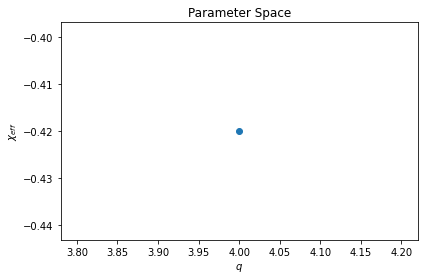

  0%|          | 0/1 [00:00<?, ?it/s]

Found the following files to load from the SXS catalog:
    SXS:BBH:1418v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [9]:
catalog_list = ['1418']
M = 50.00
theta_extrinsic = np.array([440.0, 0.0, 0.0])

theta_intrinsic_list = []
x_pos_eta = []
x_pos_q = []
y_pos = []

## initialize intrisic parameters
for catalog_number in catalog_list:
    metadata = sxs.load("SXS:BBH:"+str(catalog_number)+"/Lev/metadata.json")
    time.sleep(1)
    q = round(metadata.reference_mass_ratio * 1000) / 1000
    M = 50.0
    chi1 = metadata.reference_dimensionless_spin1[2]
    chi2 = metadata.reference_dimensionless_spin2[2]
    
    eta = q / (1 + q) ** 2.
    chi_eff = (q * chi1 + chi2) / (1 + q)
    chi_PN = chi_eff - 38 * eta * (chi1 + chi2) / 113
    chi_hat = chi_PN / (1 - 76 * eta / 113)
    
    theta_intrinsic = [M * q / (1 + q), M * 1 / (1 + q), chi1, chi2]
    theta_intrinsic_list.append(theta_intrinsic)
    x_pos_eta.append(eta)
    x_pos_q.append(q)
    y_pos.append(chi_eff)

with tqdm(total=len(catalog_list)) as pbar:
    for i, catalog_number in enumerate(catalog_list):
        ## Initialize frequency list and NR waveforms 
        f_start = 10.0
        f_end = 800.0
        delta_f = 0.01
        fs = np.arange(f_start, f_end, delta_f)
        f_sep = 100

        ## load sxs waveforms
        waveform = sxs.load("SXS:BBH:"+str(catalog_number)+"/Lev/rhOverM", extrapolation_order=4)
        waveform_l2_m2 = waveform.copy()
        waveform_l2_m2.data[...] = 0.0
        waveform_l2_m2.data[:, waveform_l2_m2.index(2, 2)] = waveform.data[:, waveform.index(2, 2)]
        waveform_l2_m2.data[:, waveform_l2_m2.index(2, -2)] = waveform.data[:, waveform.index(2, -2)]
        t_start = 0.0
        t_end = waveform_l2_m2.t[-1]
        dt = np.min(np.diff(waveform_l2_m2.t))
        t_uniform = np.arange(t_start, t_end, dt)
        h = waveform_l2_m2.interpolate(t_uniform)

        theta, phi = 0, 0
        h = h.evaluate(theta, phi)
        h = h.real

        plt.plot(t_uniform, h)
        plt.show()

        ## scale waveforms according to mass scale
        h_scaled = (M / (theta_extrinsic[0] * m_per_Mpc)) * gt * C * h 
        t_scaled = t_uniform * M * gt
        dt = t_scaled[1] - t_scaled[0]

        ## truncate waveform
        index = int(np.where(np.abs(h_scaled) == np.max(np.abs(h_scaled)))[0])
        ringdown_time = len(h_scaled) - index
        # len_new_t = (int(len(h_scaled) / float(ringdown_time)) - 1) * ringdown_time
        start_time = int(len(h_scaled) / 50)
        t_scaled = t_scaled[start_time:]
        h_scaled = h_scaled[start_time:]
        alpha = (4 * ringdown_time) / (2 * len(h_scaled))
        # alpha = 0.20

        ## tapering
        window = signal.windows.tukey(h_scaled.shape[0], alpha=alpha , sym=True) 
        h_scaled = h_scaled * window

        ## FFT
        h_tilde = np.fft.rfft(h_scaled) * dt
        freq = np.fft.rfftfreq(h_scaled.size, dt)

        ## interpolate to be based on the frequency list fs 
        tck_amp = interpolate.splrep(freq, np.abs(h_tilde), s=0)
        NR_amp = interpolate.splev(fs, tck_amp)
        tck_phase = interpolate.splrep(freq, -np.unwrap(np.angle(h_tilde)), s=0)
        NR_phase = interpolate.splev(fs, tck_phase)

        ## ## get f_RD
        NR = NR_amp * np.exp(-1j * NR_phase)
        IMR = IMRPhenomD._gen_IMRPhenomD(fs, theta_intrinsic_list[i], theta_extrinsic, get_coeffs(theta_intrinsic_list[i]), fs[0])
        NR_phase = -np.unwrap(np.angle(NR))
        NR_diff = (NR_phase[2:] - NR_phase[:-2]) / (2 * delta_f)

        tck_phase_diff = interpolate.splrep(fs[1:-1], NR_diff, s=0.1)
        NR_phase_diff = interpolate.splev(fs[1:-1], tck_phase_diff)
        for x in range(len(fs) - 3):
            if (NR_phase_diff[x+1] - NR_phase_diff[x]) < 0 and fs[x] * M * gt > 0.025:
                index = x
                break

        ## make frequency range [0.1f_RD, 1.2f_RD]
        start_index = round(0.05 * index)
        end_index = round(1.2 * index)
        f_uniform = fs[start_index:end_index]
        NR_waveform = NR[start_index:end_index]
        IMR_waveform = IMR[start_index:end_index]
        
        ## align with IMRPhenomD waveform
        NR_phase = -np.unwrap(np.angle(NR_waveform))
        IMR_phase = -np.unwrap(np.angle(IMR_waveform))
        phase_diff = NR_phase - IMR_phase
        A = np.vstack([f_uniform, np.ones(len(f_uniform))]).T
        two_pi_t0, phi0 = np.linalg.lstsq(A, phase_diff, rcond=None)[0]

        NR_waveform = NR_waveform * np.exp(1j * (two_pi_t0 * f_uniform + phi0))
        
        scale = PhenomD_coeff_table

        ## save data
        df = pd.DataFrame([])
        df.insert(len(df.columns), "frequency", f_uniform)
        df.insert(len(df.columns), "NR_real", np.real(NR_waveform))
        df.insert(len(df.columns), "NR_imag", np.imag(NR_waveform))
        # np.savetxt('/mnt/home/klam1/ceph/NR_waveform/NR_'+str(catalog_number)+'.txt', df.values)
        
        pbar.update(1)